In [165]:
import streamlit as st
from PIL import Image,ImageFilter
import torchvision.transforms as transforms
from torchvision import *
from torch import *
import time
from modelclass import *
from LabelToText import *
import random
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import cv2
import os
import gdown
from pathlib import Path
import tensorflow as tf

In [14]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def Adversarial(image, y_true, model):
    epsilons = [0.03, .05]
    examples = []
    xgrads = []
    image = image.resize((224,224))
    image = transform(image).view(1,3,224,224)
    img_variable = Variable(image, requires_grad= True)
    output = model.forward(img_variable)
    target = Variable(torch.LongTensor([y_true]),requires_grad=False)
    loss = torch.nn.CrossEntropyLoss()
    loss_cal = loss(output, target)
    loss_cal.backward(retain_graph=True)
    
    for eps in epsilons:
        x_grad = torch.sign(img_variable.grad.data)          #calculate the sign of gradient of the loss func (with respect to input X) (adv)
        x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
        #output_adv = model.forward(Variable(x_adversarial))   #perform a forward pass on adv example
        #x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]    #classify the adv example
        #op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
        #adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      #find probability (confidence) of a predicted class
        examples.append(x_adversarial)
        xgrads.append(x_grad)
    rand_idx = random.randint(0, len(examples)-1)
    random_img = examples[rand_idx]
    random_x_grad = xgrads[rand_idx]
    return random_img, random_x_grad

In [187]:
import urllib.request
def AdverarialTraining():
    #load in adverssarial network
    base = os.getcwd()
    save_dest = os.path.join(base, 'model')
    if os.path.exists(save_dest):
        pass
    else:
        os.mkdir(save_dest) 
        
        
    f_checkpoint = os.path.join(save_dest,"Resnet50.pt")
    
    if not os.path.exists(f_checkpoint):
        url = "https://www.dropbox.com/s/axfuary2w1cnyrg/imagenet_linf_4.pt?dl=0"
        u = urllib.request.urlopen(url)
        data = u.read()
        u.close()
        with open(f_checkpoint, "wb") as f :
            f.write(data)
    print(f_checkpoint)
    #model = torch.load(f_checkpoint, map_location='cpu')
    #model.load_state_dict()

    model = tf.keras.models.load_model(f_checkpoint)
    model.eval()
    return model   

In [160]:
def postprocess(x_grad, x_adv):
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.moveaxis(x_grad, 0,2)
    x_grad = np.clip(x_grad, 0, 1)

    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    #x_adv = np.moveaxis(x_grad, 0,1)
    #x_adv = np.clip(x_adv, 0, 1)
    return x_adv, x_grad

## Adversarial Attacks On Resnet 50!

In [161]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
#loading the model
resnet = Resnet()
#loaded_densenet169 = Densenet169()
#loaded_densenet169.load_state_dict(torch.load('densenet169.pt',map_location=torch.device('cpu')))
resnet.eval()
# Add a placeholder
latest_iteration = st.empty()
bar = st.progress(0)

for i in range(100):
  # Update the progress bar with each iteration.
  latest_iteration.text(f'Iteration {i+1}')
  bar.progress(i + 1)
  time.sleep(0.001)

'Resnet50 loaded!'
print('Resnet50 loaded')

Resnet50 loaded


In [162]:
uploaded_file = 'Ways-To-Keep-Your-Parrot-Happy-And-Healthy.jpg'
uploaded_file = "Fire-Truck-Romper4_1024x1024.jpg"
"""Or choose whatever Image file you wish"""

'Or choose whatever Image file you wish'

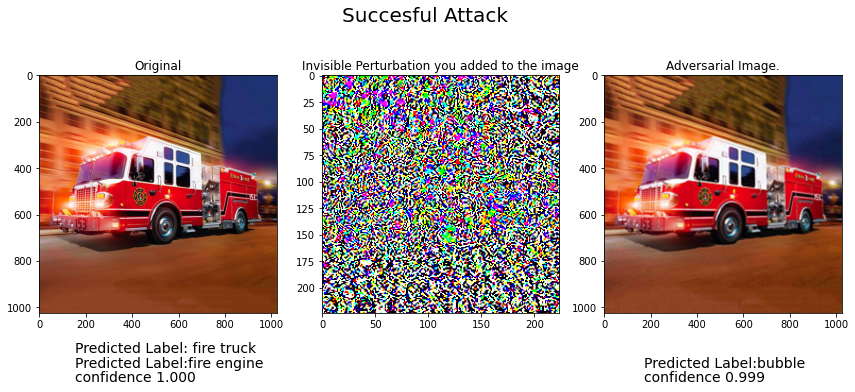

In [163]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

if uploaded_file != None:
    image = Image.open(uploaded_file)
    image = image.filter(ImageFilter.MedianFilter)
    im = image
    axs[0].imshow(image)
    axs[0].title.set_text('Uploaded Image.')
    origial_size = image.size
    image = image.resize((224,224))
    image = transform(image).view(1,3,224,224)
    pred  = resnet.forward(image)
    proba,idx = torch.max(torch.sigmoid(pred),dim = 1)

    proba = proba.detach().numpy()[0]
    idx = idx.numpy()[0]    


    axs[0].title.set_text('''Original''')
    label_oracle = Labels()
    pred_label = label_oracle.label(idx)
    label_str = pred_label.split(',')
    g= 0
    for x in label_str:
        plt.gcf().text(0.091, -.1 + g, 'Predicted Label:' + x, fontsize=14)
        g += .05
    plt.gcf().text(0.091, -.15, 'confidence {:0.3f}'.format(float(proba)), fontsize=14)
    im, x_grad =  Adversarial(im, idx, resnet)
    im, x_grad  = postprocess(x_grad, im)
    axs[1].imshow(x_grad)
    axs[1].title.set_text('Invisible Perturbation you added to the image')
    first_idx = idx
    temp = cv2.resize(im, dsize=origial_size, interpolation=cv2.INTER_CUBIC)
    temp = np.clip(temp, 0, 1)
    axs[2].imshow(temp)
    axs[2].title.set_text('Adversarial Image.')
    
    im = Image.fromarray(np.uint8(im)*255)
    im = im.resize((224,224))
    im = transform(im).view(1,3,224,224)


    pred  = resnet.forward(im)
    proba,idx = torch.max(torch.sigmoid(pred),dim = 1)
    
    proba = proba.detach().numpy()[0]
    idx = idx.numpy()[0]
    second_idx = idx
    if first_idx == second_idx :
        print("Wait... How'd You do that? *Double or nothin* :sunglasses: ")
        plt.gcf().text(.4, 1.1, 'Failed Attack', fontsize=20)
    else:
        plt.gcf().text(.4, 1.1, 'Succesful Attack', fontsize=20)
    pred_label = label_oracle.label(idx)
    label_str = pred_label.split(',')
    for x in label_str:
        plt.gcf().text(.75, -.1, 'Predicted Label:' + x, fontsize=14)
    plt.gcf().text(.75, -.15, 'confidence {:0.3f}'.format(float(proba)), fontsize=14)
    st.subheader("Explanation Below")
    plt.tight_layout()


Hows this attack Work?

 > $$adversarial_{image} =  \sin(\triangledown_{input} J(0,input,y_{true}))$$


 ## The attack you just implemented is known as the FGSM attack.
 This attack first introduced by Ian Goodfellow uses the optimized gradients
 of the nerual networks output (the processed image tensor) to maximize loss
 between the target class and the predicted class. The attack optimizes on 
 the L_infity metric between the input image and the adversarial image. 
 The L-Infinity distance judges the pixel with the largest amount of change. 
 This attack takes "steps" (Cough Cough Gradient Descent Sound familiar?) 
 to figure out which direction creates the most loss. In this way were not 
 actually targeting any particular label but instead ensuring that the model 
 doesnt predict the true label. 
col.write("https://www.mdpi.com/2079-9292/9/8/1284/htm")